# Aptos EDA



# Data Insight:

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import os

## Reading data and Basic EDA

From here, I start to read data into pandas and start basic EDA.

In [3]:
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

df.head(20)

,diagnosis,path
0,0,../input/aptos2019-blindness-detection/train_i...
1,2,../input/aptos2019-blindness-detection/train_i...
2,0,../input/aptos2019-blindness-detection/train_i...
3,2,../input/aptos2019-blindness-detection/train_i...
4,1,../input/aptos2019-blindness-detection/train_i...
5,0,../input/aptos2019-blindness-detection/train_i...
6,3,../input/aptos2019-blindness-detection/train_i...
7,0,../input/aptos2019-blindness-detection/train_i...
8,1,../input/aptos2019-blindness-detection/train_i...
9,0,../input/aptos2019-blindness-detection/train_i...


In [4]:
len_df = len(df)
print(f"There are {len_df} training images")

There are 3662 training images


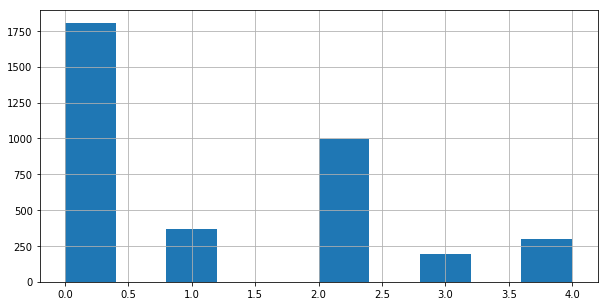

In [5]:
df['diagnosis'].hist(figsize = (10, 5))

This dataset is highly imbalanced. Most of the data is at level 0 and level 2, which is No DR and Moderate. Interestingly I expected level 1 to be more than level 2. From this information, I can assume that it is very hard to look for symptoms. 

Let's look at an example image:

In [6]:
from PIL import Image

im = Image.open(df['path'][2])
width, height = im.size
print(width,height) 
im.show()

1050 1050


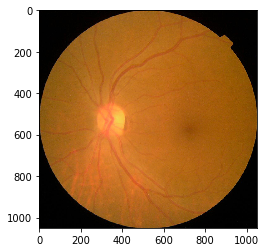

In [7]:
plt.imshow(np.asarray(im))

The images are actually quite big. We will resize to a much smaller size.

In [8]:
bs = 64 #smaller batch size is better for training, but may take longer
sz=224

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

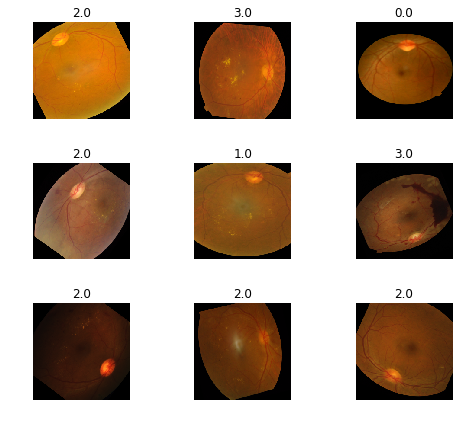

In [10]:
data.show_batch(rows=3, figsize=(7,6))